# Demonstrate bias in hierarchical modeling of power law

### We construct time-domain data obeying a power law. The data is modeled using a collection of Fourier coefficients, and hierarchically modeled with an amplitude and spectral index which describe the power law. We observe bias in the hyper-parameters depending on the number of frequency bins included in the model.

# Simulate data

In [2]:
from jax import vmap
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from corner import corner

from BayesFT import functions as f
from simulate_data import power_law
from BayesFT import hierarchical_models as hm
from BayesFT.PTMCMC import PTMCMC
from BayesFT import jumps

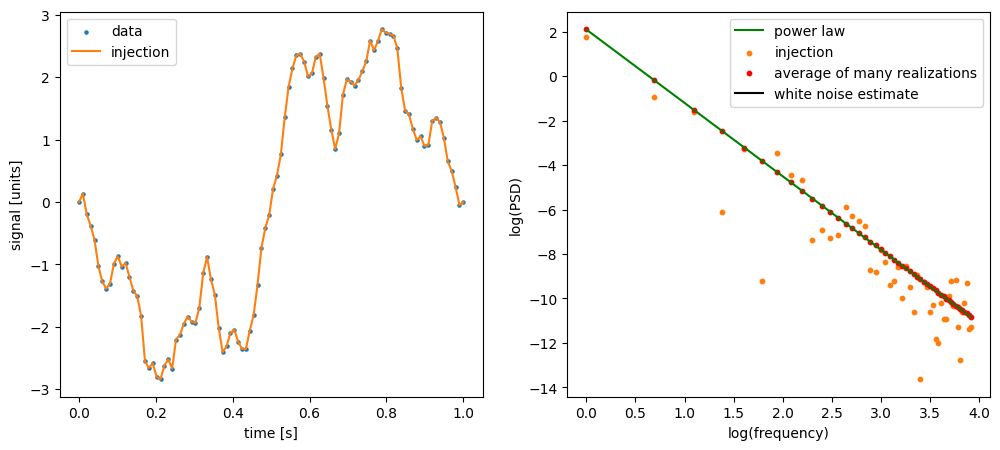

In [3]:
# time series over which data is collected
t0 = 0.
t1 = 1.
Nt = 100
times = jnp.linspace(t0, t1, Nt)

# hyper-parameters to inject in power law
log_amp_inj = 1.4
gamma_inj = 3.3
hypers_inj = jnp.array([log_amp_inj, gamma_inj])

# white noise level
noise_log_stdev = -100.0
Data_object = power_law.sim_power_law(log_amp_inj, gamma_inj, times, noise_log_stdev, 3)
data = Data_object.data_values

# Model specification

In [5]:
# compare bias in two models
model_1_Nf = 3  # number of frequency bins in model 1
model_2_Nf = 10  # number of frequency bins in model 2
model_1 = hm.Hierarchical_Model(times, data, model_1_Nf)
model_2 = hm.Hierarchical_Model(times, data, model_2_Nf)

# point near maximum likelihood (ML) solution
a_ML_1 = jnp.linalg.pinv(model_1.F) @ data
log_sigma_ML_1 = jnp.log(jnp.sqrt(jnp.sum((data - model_1.F @ a_ML_1)**2.) / Nt))
x_ML_1 = jnp.concatenate((hypers_inj, a_ML_1, jnp.array([log_sigma_ML_1])))

a_ML_2 = jnp.linalg.pinv(model_2.F) @ data
log_sigma_ML_2 = jnp.log(jnp.sqrt(jnp.sum((data - model_2.F @ a_ML_2)**2.) / Nt))
x_ML_2 = jnp.concatenate((hypers_inj, a_ML_2, jnp.array([log_sigma_ML_2])))

# MCMC

In [7]:
# jump proposals: Fisher and differential evolution
Fisher_1 = jumps.FisherJumps(x_ML_1, model_1.fast_lnpost)
DEjumps_1 = jumps.DifferentialEvolution(100, model_1.x_min, model_1.x_max)
jump_proposals_1 = [[Fisher_1.vectorized_Fisher_jump, 20],
                      [DEjumps_1.vectorized_DE_jump, 10]]

# do parallel tempering MCMC
num_samples = int(1e4)
num_chains = 5
samples_1, lnposts_1, temp_ladder_1 = PTMCMC(num_samples=num_samples,
                                             num_chains=num_chains,
                                             x0=x_ML_1,
                                             lnpost_func=model_1.fast_lnpost,
                                             # lnpost_func=model_Nf4.fast_lnprior_recovery,
                                             jump_proposals=jump_proposals_1,
                                             PT_weight=10)

Jump acceptance rates
Fisher_jump: [0.55935574 0.54901571 0.5255518  0.50606482 0.47922052]
DE_jump: [0.08162461 0.07413249 0.0887224  0.08359621 0.10252366]
PT swap: [0.70254725 0.69515201 0.71117502 0.72966311        nan]


/Users/aidengundersen/Desktop/BayesFT/BayesFT/PTMCMC.py:167: RuntimeWarning: invalid value encountered in divide
  acceptance_rates = accept_counts / (accept_counts + reject_counts)


In [8]:
# jump proposals: Fisher and differential evolution
Fisher_2 = jumps.FisherJumps(x_ML_2, model_2.fast_lnpost)
DEjumps_2 = jumps.DifferentialEvolution(100, model_2.x_min, model_2.x_max)
jump_proposals_2 = [[Fisher_2.vectorized_Fisher_jump, 20],
                      [DEjumps_2.vectorized_DE_jump, 10]]

# do parallel tempering MCMC
samples_2, lnposts_2, temp_ladder_2 = PTMCMC(num_samples=num_samples,
                                             num_chains=num_chains,
                                             x0=x_ML_2,
                                             lnpost_func=model_2.fast_lnpost,
                                             # lnpost_func=model_Nf4.fast_lnprior_recovery,
                                             jump_proposals=jump_proposals_2,
                                             PT_weight=10)

Jump acceptance rates
Fisher_jump: [0.63771057 0.64278466 0.61355795 0.60138015 0.58006901]
DE_jump: [0.03571429 0.03456221 0.03072197 0.03763441 0.03456221]
PT swap: [0.50445705 0.52147488 0.3691248  0.53119935        nan]


/Users/aidengundersen/Desktop/BayesFT/BayesFT/PTMCMC.py:167: RuntimeWarning: invalid value encountered in divide
  acceptance_rates = accept_counts / (accept_counts + reject_counts)


# Post-processing

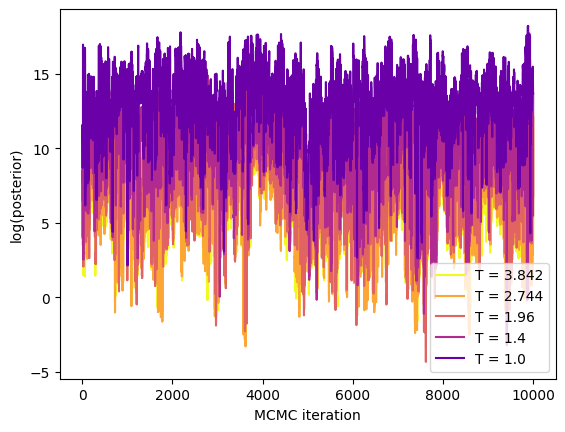

In [9]:
# plot posterior values of chains (with temperature scaling)
chain_colors = list(reversed([plt.cm.plasma(i / num_chains) for i in range(1, num_chains + 1)]))
for j, (temp, color) in enumerate(zip(temp_ladder_1[::-1], chain_colors)):
    plt.plot(lnposts_1[::-1][j], color=color, label=f'T = {round(temp, 3)}')
plt.xlabel('MCMC iteration')
plt.ylabel('log(posterior)')
plt.legend(loc='lower right')
plt.show()

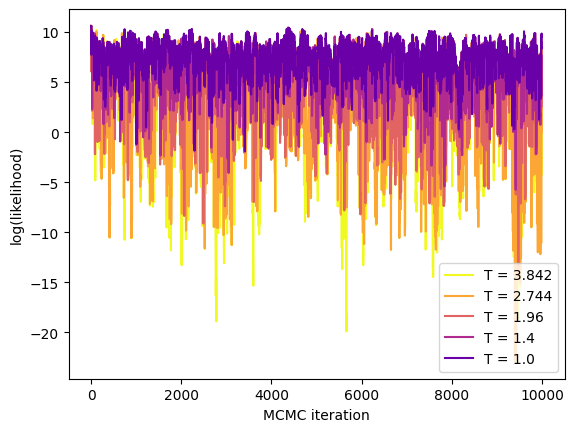

In [10]:
# plot likelihood values (without temperature scaling)
vectorized_lnlike = vmap(model_1.fast_lnlike)
for j, (temp, color) in enumerate(zip(temp_ladder_1[::-1], chain_colors)):
    plt.plot(vectorized_lnlike(samples_1[::-1][j]), color=color, label=f'T = {round(temp, 3)}')
plt.xlabel('MCMC iteration')
plt.ylabel('log(likelihood)')
plt.legend(loc='lower right')
plt.show()

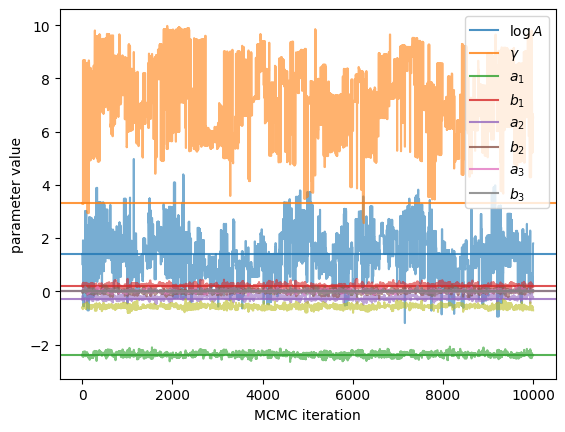

In [11]:
# parameter trace plot
ndim = samples_1[0,0].shape[0]
for i in range(ndim):
    plt.plot(samples_1[0,:,i], color=f'C{i}', alpha=0.6)
    if i != ndim - 1:
        plt.axhline(x_ML_1[i], color=f'C{i}', label=model_1.labels[i], alpha=0.8)
plt.xlabel('MCMC iteration')
plt.ylabel('parameter value')
plt.legend(loc='upper right')
plt.show()

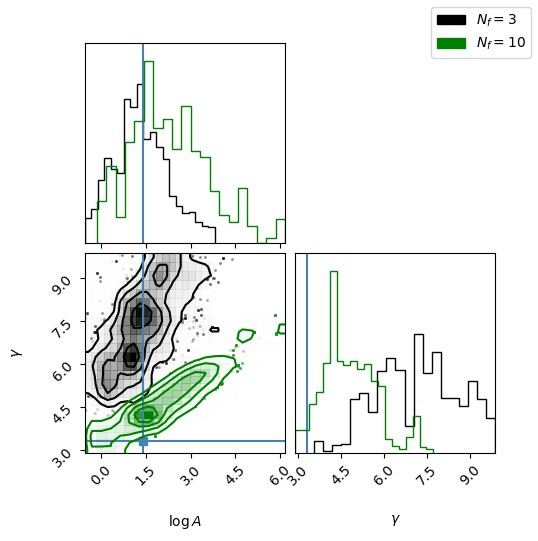

In [12]:
# corner plot
ndxs = np.arange(2)
burnin = num_samples // 5
nsamp = num_samples - burnin

fig = corner(samples_1[0, burnin:][:, ndxs],
             truths=x_ML_1[ndxs],
             labels=model_1.labels[ndxs],
             weights=np.ones(nsamp)/nsamp,
             range=[0.99]*ndxs.shape[0],
             smooth=1.0)

corner(samples_2[0, burnin:][:, ndxs], color='green',
       weights=np.ones(nsamp)/nsamp, fig=fig,
       smooth=1.0)

black_patch = mpatches.Patch(color='black', label=rf'$N_f={model_1_Nf}$')
green_patch = mpatches.Patch(color='green', label=rf'$N_f={model_2_Nf}$')
fig.legend(handles=[black_patch, green_patch], loc='upper right')
plt.show()

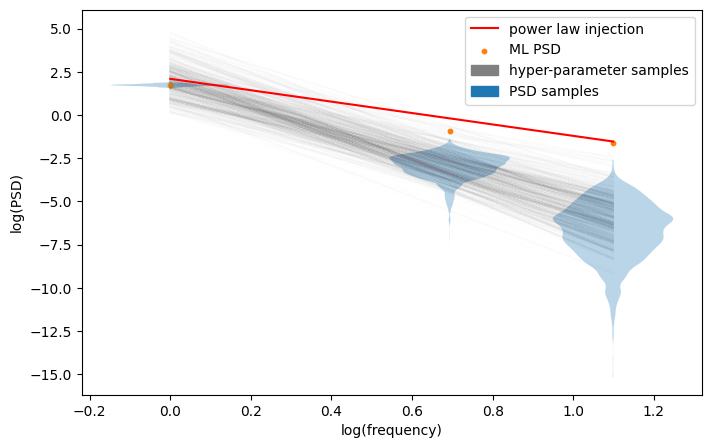

In [13]:
# violin plot
f_inj = Data_object.freq_bins
logf_inj = np.log(f_inj)
diag_cov_inj = f.fast_diag_power_law_cov(log_amp_inj, gamma_inj, f_inj)
logPSDs = np.log(samples_1[0, burnin:, 2::2][:,:-1]**2. + samples_1[0, burnin:, 3::2]**2.)
plt.figure(figsize=(8, 5))
plt.violinplot(logPSDs,
               positions=logf_inj[:model_1_Nf],
               showextrema=False,
               widths=0.3)

# plot power law using fair draws
num_fair_draws = 1000
fair_draw_ndxs = np.random.choice(np.arange(burnin, num_samples), num_fair_draws)
for ndx in fair_draw_ndxs:
    diag_cov = f.fast_diag_power_law_cov(samples_1[0, ndx, 0], samples_1[0, ndx, 1], f_inj[:model_1_Nf])
    plt.plot(logf_inj[:model_1_Nf], np.log(diag_cov[::2] + diag_cov[1::2]), alpha=5./num_fair_draws, color='grey')
plt.plot(logf_inj[:model_1_Nf], np.log(diag_cov_inj[::2] + diag_cov_inj[1::2])[:model_1_Nf], color='red',
         label='power law injection')

# injected PSD
plt.scatter(logf_inj[:model_1_Nf], Data_object.logPSD_ML[:model_1_Nf], color='C1', s=10,
            label='ML PSD')

# make legend
grey_patch = mpatches.Patch(color='grey', label='hyper-parameter samples')
blue_patch = mpatches.Patch(color='C0', label='PSD samples')
handles, labels = plt.gca().get_legend_handles_labels()
handles += [grey_patch, blue_patch]  # Add custom patches to the handles
labels += ['hyper-parameter samples', 'PSD samples']  # Add corresponding labels
plt.legend(handles=handles, labels=labels, loc='upper right')

plt.xlabel('log(frequency)')
plt.ylabel('log(PSD)')
plt.show()

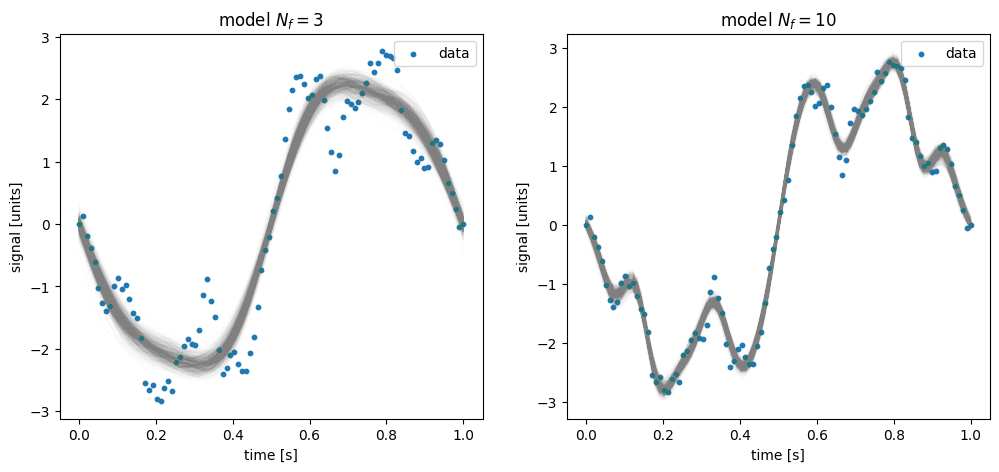

In [14]:
# Bayesogram

# fair draws from posterior
num_draws = 1000
draw_ndxs = np.random.choice(np.arange(burnin, num_samples))

# model 1 time-domain recovery
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(times, data, color='C0', s=10, label='data')
[plt.plot(times, model_1.F @ samples_1[0, ndx, 2:-1], color='grey', alpha=5./num_fair_draws)
 for ndx in fair_draw_ndxs]
plt.xlabel('time [s]')
plt.ylabel('signal [units]')
plt.legend(loc='upper right')
plt.title(rf'model $N_f = {model_1_Nf}$')

# model 2 time-domain recovery
plt.subplot(1, 2, 2)
plt.scatter(times, data, color='C0', s=10, label='data')
[plt.plot(times, model_2.F @ samples_2[0, ndx, 2:-1], color='grey', alpha=5./num_fair_draws)
 for ndx in fair_draw_ndxs]
plt.xlabel('time [s]')
plt.ylabel('signal [units]')
plt.legend(loc='upper right')
plt.title(rf'model $N_f = {model_2_Nf}$')
plt.show()